In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml


from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(df):
    weights = np.array([
        0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
        0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
        0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
        0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
        0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
        0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
        0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
        0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
        0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
        0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
        0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
        0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
        0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
        0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
        0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
        0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
        0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
    ])
    df.eval('day_of_week = date_id % 5', inplace=True) 
    df.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df.eval('diff_ask_price_bid_price = ask_price - bid_price', inplace=True)
    df.eval('diff_ask_price_reference_price = ask_price - reference_price', inplace=True)
    df.eval('diff_bid_price_reference_price = bid_price - reference_price', inplace=True)
    df.eval('diff_ask_price_wap = ask_price - wap', inplace=True)
    df.eval('diff_bid_price_wap = bid_price - wap', inplace=True)
    df.eval('diff_far_price_near_price = far_price - near_price', inplace=True)
    df.eval('diff_far_price_reference_price = far_price - reference_price', inplace=True)
    df.eval('diff_near_price_reference_price = near_price - reference_price', inplace=True)
    df.eval('diff_ask_size_bid_size = ask_size - bid_size', inplace=True)
    df.eval('diff_ask_size_matched_size = ask_size - matched_size', inplace=True)
    df.eval('diff_bid_size_matched_size = bid_size - matched_size', inplace=True)
    df.eval('diff_imbalance_size_matched_size = imbalance_size - matched_size', inplace=True)
    df.eval('sum_ask_price_bid_price = ask_price + bid_price', inplace=True)
    df.eval('sum_far_price_near_price = far_price + near_price', inplace=True)
    df.eval('midpoint_price = (ask_price + bid_price) / 2', inplace=True)
    df.eval('midpoint_size = (ask_size + bid_size) / 2', inplace=True)
    df.eval('wap_factor1 = (bid_size * ask_price) / (bid_size + ask_size)', inplace=True)
    df.eval('wap_factor2 = (ask_size * bid_price) / (bid_size + ask_size)', inplace=True)
    df.eval('diff_wap_factor1_wap_factor2 = wap_factor1 - wap_factor2', inplace=True)
    df.eval('feature1 = near_price / far_price', inplace=True)
    df.eval('feature2 = (ask_price - bid_price) / (reference_price - bid_price)', inplace=True)
    df.eval('feature3 = (bid_price - ask_price) / (reference_price - ask_price)', inplace=True)
    df.eval('feature4 = (ask_price - reference_price) / (bid_price - reference_price)', inplace=True)
    df.eval('feature5 = (ask_price - wap) / (bid_price - wap)', inplace=True)
    df.eval('feature6 = (ask_size - bid_size) / (matched_size - bid_size)', inplace=True)
    df.eval('feature7 = (bid_size - ask_size) / (matched_size - ask_size)', inplace=True)
    df.eval('feature8 = (ask_size - bid_size) / (imbalance_size - bid_size)', inplace=True)
    df.eval('feature9 = (bid_size - ask_size) / (imbalance_size - ask_size)', inplace=True)
    df.eval('feature10 = (reference_price - midpoint_price) / (ask_price - midpoint_price)', inplace=True)
    df.eval('feature11 = (ask_price - bid_price) / ask_price', inplace=True)
    df.eval('feature12 = (ask_price - reference_price) / ask_price', inplace=True)
    df.eval('feature13 = (bid_price - reference_price) / ask_price', inplace=True)
    df.eval('feature14 = (ask_size - bid_size) / ask_size', inplace=True)
    df.eval('feature15 = (matched_size - ask_size) / matched_size', inplace=True)
    df.eval('feature16 = (matched_size - bid_size) / matched_size', inplace=True)
    df.eval('feature17 = (matched_size - imbalance_size) / matched_size', inplace=True)
    transform_features = [
        'imbalance_size',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_price_bid_price',
        'diff_ask_price_reference_price',
        'diff_bid_price_reference_price',
        'diff_ask_price_wap',
        'diff_bid_price_wap',
        'diff_far_price_near_price',
        'diff_far_price_reference_price',
        'diff_near_price_reference_price',
        'diff_ask_size_bid_size',
        'diff_ask_size_matched_size',
        'diff_bid_size_matched_size',
        'diff_imbalance_size_matched_size',
        'sum_ask_price_bid_price',
        'sum_far_price_near_price',
        'midpoint_price',
        'midpoint_size',
        'wap_factor1',
        'wap_factor2',
        'diff_wap_factor1_wap_factor2',
        'feature1',
        'feature2',
        'feature3',
        'feature4',
        'feature5',
        'feature6',
        'feature7',
        'feature8',
        'feature9',
        'feature10',
        'feature11',
        'feature12',
        'feature13',
        'feature14',
        'feature15',
        'feature16',
        'feature17',
    ]
    robust_scaled_df = (
        df
        .groupby(['date_id', 'seconds_in_bucket'])[transform_features]
        .transform(lambda x: (x - x.quantile(0.50)) / (x.quantile(0.75) - x.quantile(0.25)))
    )
    robust_scaled_df.columns = ['robust_scaled_'+col for col in robust_scaled_df.columns]
    
    df = pd.concat([df, robust_scaled_df], axis=1)
    df.drop(columns=['row_id'], inplace=True)
    return df

In [3]:
def preprocess_by_pl(df: pd.DataFrame):
    df = pl.from_pandas(df)
    new_features1 = [
        (pl.col('date_id') % 5).alias('day_of_week'),
        (pl.col('imbalance_buy_sell_flag') + 1).alias('imbalance_buy_sell_flag'),
        (pl.col('ask_price') - pl.col('bid_price')).alias('diff_ask_price_bid_price'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('diff_ask_price_reference_price'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('diff_bid_price_reference_price'),
        (pl.col('ask_price') - pl.col('wap')).alias('diff_ask_price_wap'),
        (pl.col('bid_price') - pl.col('wap')).alias('diff_bid_price_wap'),
        (pl.col('far_price') - pl.col('near_price')).alias('diff_far_price_near_price'),
        (pl.col('far_price') - pl.col('reference_price')).alias('diff_far_price_reference_price'),
        (pl.col('near_price') - pl.col('reference_price')).alias('diff_near_price_reference_price'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('diff_ask_size_bid_size'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('diff_ask_size_matched_size'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('diff_bid_size_matched_size'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('diff_imbalance_size_matched_size'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('sum_ask_price_bid_price'),
        (pl.col('far_price') + pl.col('near_price')).alias('sum_far_price_near_price'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('sum_ask_size_bid_size'),
        (pl.col('ask_price') / 2 + pl.col('bid_price') / 2).alias('midpoint_price'),
        (pl.col('ask_size') / 2 + pl.col('bid_size') / 2).alias('midpoint_size'),
        (pl.col('bid_size') * pl.col('ask_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor1'),
        (pl.col('ask_size') * pl.col('bid_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor2'),
        (pl.col('near_price') / pl.col('far_price')).alias('feature1'),
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature2'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature3'),
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature4'),
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature5'),
        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature6'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature7'),
        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature8'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature9'),
        ((pl.col('ask_price') - pl.col('bid_price')) / pl.col('ask_price')).alias('feature10'),
        ((pl.col('ask_price') - pl.col('reference_price')) / pl.col('ask_price')).alias('feature11'),
        ((pl.col('bid_price') - pl.col('reference_price')) / pl.col('bid_price')).alias('feature12'),
        ((pl.col('ask_size') - pl.col('bid_size')) / pl.col('ask_size')).alias('feature13'),
        ((pl.col('matched_size') - pl.col('ask_size')) / pl.col('matched_size')).alias('feature14'),
        ((pl.col('matched_size') - pl.col('bid_size')) / pl.col('matched_size')).alias('feature15'),
        ((pl.col('matched_size') - pl.col('imbalance_size')) / pl.col('matched_size')).alias('feature16'),
    ]
    
    new_features2 = [
        (((pl.col('reference_price')) - pl.col('midpoint_price')) / (pl.col('ask_price') - pl.col('midpoint_price'))).alias('feature17'),
        (pl.col('wap_factor1') - pl.col('wap_factor2')).alias('diff_wap_factor1_wap_factor2'),
    ]

    transform_features = [
        'imbalance_size',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_price_bid_price',
        'diff_ask_price_reference_price',
        'diff_bid_price_reference_price',
        'diff_ask_price_wap',
        'diff_bid_price_wap',
        'diff_far_price_near_price',
        'diff_far_price_reference_price',
        'diff_near_price_reference_price',
        'diff_ask_size_bid_size',
        'diff_ask_size_matched_size',
        'diff_bid_size_matched_size',
        'diff_imbalance_size_matched_size',
        'sum_ask_price_bid_price',
        'sum_far_price_near_price',
        'midpoint_price',
        'midpoint_size',
        'wap_factor1',
        'wap_factor2',
        'diff_wap_factor1_wap_factor2',
        'feature1',
        'feature2',
        'feature3',
        'feature4',
        'feature5',
        'feature6',
        'feature7',
        'feature8',
        'feature9',
        'feature10',
        'feature11',
        'feature12',
        'feature13',
        'feature14',
        'feature15',
        'feature16',
        'feature17',
    ]

    new_features3 = [
        ((pl.col(feature) - pl.col(feature).quantile(0.5)) / (pl.col(feature).quantile(0.75) - pl.col(feature).quantile(0.25)))
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'robust_scaled_{feature}')
        for feature in transform_features
    ]

    df = (
        df
        .with_columns(new_features1)
        .with_columns(new_features2)
        .with_columns(new_features3)
        .drop(['row_id'])
    )
    return df.to_pandas()

In [4]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['time_id'], inplace=True)
train_df = preprocess_by_pl(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,day_of_week,diff_ask_price_bid_price,diff_ask_price_reference_price,diff_bid_price_reference_price,diff_ask_price_wap,diff_bid_price_wap,diff_far_price_near_price,diff_far_price_reference_price,diff_near_price_reference_price,diff_ask_size_bid_size,diff_ask_size_matched_size,diff_bid_size_matched_size,diff_imbalance_size_matched_size,sum_ask_price_bid_price,sum_far_price_near_price,sum_ask_size_bid_size,midpoint_price,midpoint_size,wap_factor1,wap_factor2,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,diff_wap_factor1_wap_factor2,robust_scaled_imbalance_size,robust_scaled_reference_price,robust_scaled_matched_size,robust_scaled_far_price,robust_scaled_near_price,robust_scaled_bid_price,robust_scaled_bid_size,robust_scaled_ask_price,robust_scaled_ask_size,robust_scaled_wap,robust_scaled_diff_ask_price_bid_price,robust_scaled_diff_ask_price_reference_price,robust_scaled_diff_bid_price_reference_price,robust_scaled_diff_ask_price_wap,robust_scaled_diff_bid_price_wap,robust_scaled_diff_far_price_near_price,robust_scaled_diff_far_price_reference_price,robust_scaled_diff_near_price_reference_price,robust_scaled_diff_ask_size_bid_size,robust_scaled_diff_ask_size_matched_size,robust_scaled_diff_bid_size_matched_size,robust_scaled_diff_imbalance_size_matched_size,robust_scaled_sum_ask_price_bid_price,robust_scaled_sum_far_price_near_price,robust_scaled_midpoint_price,robust_scaled_midpoint_size,robust_scaled_wap_factor1,robust_scaled_wap_factor2,robust_scaled_diff_wap_factor1_wap_factor2,robust_scaled_feature1,robust_scaled_feature2,robust_scaled_feature3,robust_scaled_feature4,robust_scaled_feature5,robust_scaled_feature6,robust_scaled_feature7,robust_scaled_feature8,robust_scaled_feature9,robust_scaled_feature10,robust_scaled_feature11,robust_scaled_feature12,robust_scaled_feature13,robust_scaled_feature14,robust_scaled_feature15,robust_scaled_feature16,robust_scaled_feature17
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0.000214,0.000214,0.000000,0.000026,-0.000188,NaN,NaN,NaN,-52158.47,-13371783.61,-13319625.14,-10199673.95,1.999838,NaN,69144.53,0.999919,34572.265,0.877193,0.122807,NaN,inf,1.000000,inf,-0.138298,-0.003916,0.003901,-0.016718,0.016443,0.000214,0.000214,0.000000,-6.141326,0.999365,0.995467,0.762292,-1.000000,0.754386,0.328788,-0.219344,1.079826,NaN,NaN,0.002415,1.583755,-0.549161,-0.282812,NaN,-0.626623,-0.223975,0.330020,-0.549161,0.002415,NaN,NaN,NaN,-1.626072,-1.079072,-1.075850,-1.364923,-0.332649,NaN,-0.332649,0.612922,0.738668,-0.738669,0.738668,NaN,inf,0.000000,inf,0.279252,-0.629868,0.626851,-0.817593,0.807267,-0.625967,-0.223763,0.329967,-2.469488,0.320211,-0.234463,0.208048,-0.320014
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0.000764,0.000764,0.000000,0.000660,-0.000104,NaN,NaN,NaN,17372.05,-1621609.16,-1638981.21,-1475610.34,2.000556,NaN,23838.13,1.000278,11919.065,0.135714,0.864285,NaN,inf,1.000000,inf,-6.346154,0.010599,-0.010713,0.106335,-0.118988,0.000763,0.000763,0.000000,0.843095,0.987453,0.998031,0.898549,-1.000000,-0.728571,-0.299431,-0.074266,-0.366964,NaN,NaN,0.205314,-0.355815,0.971223,0.142285,NaN,0.266234,0.643533,0.330020,0.971223,0.205314,NaN,NaN,NaN,0.539757,0.367832,0.366784,0.124932,1.141684,NaN,1.141684,-0.244357,-0.713389,0.713391,-0.713391,NaN,inf,0.000000,inf,-1.732530,1.674790,-1.691218,5.200320,-5.841654,0.265961,0.643201,0.329967,0.337972,-1.078083,0.085663,0.415625,-0.320014
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0.000895,0.000737,-0.000158,0.000298,-0.000597,NaN,NaN,NaN,-18961.00,-1800373.03,-1781412.03,-1516488.

## train catboost models using cross validation

In [5]:
def train(
        dataset: pd.DataFrame,
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'ask_size', 'bid_size']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
        'test_mae': [],
    }
    valid_time = time[-120:-60]
    test_time = time[-60:]
    valid_X = dataset.query('date_id in @valid_time')[feature_columns]
    valid_y = dataset.query('date_id in @valid_time')[target_columns]
    test_X = dataset.query('date_id in @test_time')[feature_columns]
    test_y = dataset.query('date_id in @test_time')[target_columns]
    train_times = [(300, 360), (240, 360), (180, 360), (120, 360), (60, 360), (0, 360)]
    for k, train_time in enumerate(train_times):
        train_indices = np.arange(*train_time)
        print(f'fold {k+1}')
        train_time = time[train_indices]
        print(train_time)
        print(valid_time)
        print(test_time)
        print(train_time.shape, np.min(train_time), np.max(train_time))
        print(valid_time.shape, np.min(valid_time), np.max(valid_time))
        print(test_time.shape, np.min(test_time), np.max(test_time))
        
        plot_time(time, train_time, valid_time, test_time)
        
        train_X = dataset.query('date_id in @train_time')[feature_columns]
        train_y = dataset.query('date_id in @train_time')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        print(f'test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}')
        
        objective = Objective(train_X, train_y['target'], valid_X, valid_y['target'])
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=2)

        best_params = study.best_params
        add_params = {
            'loss_function': 'MAE',
            'eval_metric': 'MAE',
            'iterations': 5000,
            'random_state': 42,
            'bootstrap_type': 'Poisson',
            'task_type': 'GPU',
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')
        
        train_pool = Pool(
            data=train_X.values,
            label=train_y['target'].values,
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        valid_pool = Pool(
            data=valid_X.values,
            label=valid_y['target'].values,
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = CatBoostRegressor(**best_params)
        model.fit(
            X=train_pool,
            eval_set=[(valid_pool)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=100,
        )
        model.save_model(
            outputs_dir.joinpath(f'catboost_optuna_group_fold{k+1}'),
        )
        
        best_params['num_boost_round'] = model.get_best_iteration()
        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value

        fimp = model.get_feature_importance(valid_pool, type='PredictionValuesChange')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        test_y[f'regression_fold{k+1}'] = model.predict(test_X)

        history['train_mae'].append(
            mean_absolute_error(
                train_y['target'],
                model.predict(train_X)
            )
        )
        history['valid_mae'].append(
            mean_absolute_error(
                valid_y['target'],
                model.predict(valid_X)
            )
        )
        history['test_mae'].append(
            mean_absolute_error(
                test_y['target'],
                model.predict(test_X)
            )
        )
        
        del objective, study
        del train_X, train_y, train_pool, valid_pool, model, fimp
        gc.collect()


    history = pd.DataFrame.from_dict(history)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    
    test_y['regression'] = test_y[[f'regression_fold{k+1}' for k in range(len(train_times))]].mean(axis=1)
    test_y_mae = mean_absolute_error(test_y['target'], test_y['regression'])
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, test_y, fimps, best_param_records


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'loss_function': 'MAE',
            'eval_metric': 'MAE',
            'iterations': 5000,
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'random_state': 42,
            # 'bagging_temperature': trial.suggest_float(
            #     'bagging_temperature', 0.01, 100.00
            # ),
            # 'random_strength': trial.suggest_float(
            #     'random_strength', 0.01, 100.00
            # ),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
            #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 1),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'bootstrap_type': 'Poisson',
            'task_type': 'GPU',
        }
        
        train_pool = Pool(self.train_X.values, self.train_y.values)
        valid_pool = Pool(self.valid_X.values, self.valid_y.values)
        model = CatBoostRegressor(**params)
        model.fit(
            train_pool,
            eval_set=[(valid_pool)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=False,
        )

        preds = model.predict(valid_pool)
        mae = mean_absolute_error(preds, self.valid_y.values)

        del params, train_pool, valid_pool, model, preds
        gc.collect()

        return mae
    

def plot_time(all_time, train_time, valid_time, test_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time), len(test_time)],
            left=[train_time.min(), valid_time.min(), test_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2, test_time.min()+len(test_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}', f'test\n{len(test_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), valid_time.min(), test_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

fold 1
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359]
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419]
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479]
(60,) 300 359
(60,) 360 419
(60,) 420 479


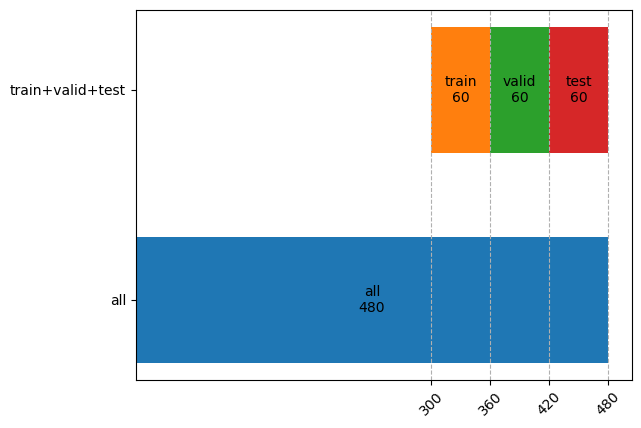

[I 2023-11-16 03:29:21,249] A new study created in memory with name: no-name-c615141f-3b5b-481c-9847-344c77f93a6d


train_X.shape: (659944, 97), train_y.shape: (659944, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 6)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.377393387270782


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4650357	test: 6.4920205	best: 6.4920205 (0)	total: 4.56ms	remaining: 22.8s
100:	learn: 6.4233723	test: 6.4526627	best: 6.4526627 (100)	total: 425ms	remaining: 20.6s
200:	learn: 6.4033107	test: 6.4344559	best: 6.4344559 (200)	total: 851ms	remaining: 20.3s
300:	learn: 6.3916522	test: 6.4241194	best: 6.4241194 (300)	total: 1.28s	remaining: 20s
400:	learn: 6.3838583	test: 6.4177856	best: 6.4177856 (400)	total: 1.7s	remaining: 19.5s
500:	learn: 6.3778215	test: 6.4133307	best: 6.4133307 (500)	total: 2.12s	remaining: 19s
600:	learn: 6.3722263	test: 6.4094902	best: 6.4094902 (600)	total: 2.55s	remaining: 18.7s
700:	learn: 6.3674183	test: 6.4061399	best: 6.4061399 (700)	total: 2.98s	remaining: 18.3s
800:	learn: 6.3629550	test: 6.4033927	best: 6.4033927 (800)	total: 3.39s	remaining: 17.8s
900:	learn: 6.3590532	test: 6.4010455	best: 6.4010455 (900)	total: 3.82s	remaining: 17.4s
1000:	learn: 6.3557196	test: 6.3989855	best: 6.3989855 (1000)	total: 4.25s	remaining: 17s
1100:	learn: 6.352

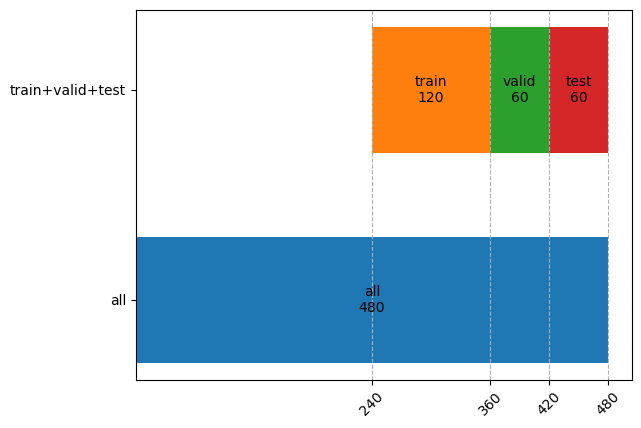

train_X.shape: (1316919, 97), train_y.shape: (1316919, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 7)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.371907970078059


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.2427921	test: 6.4923077	best: 6.4923077 (0)	total: 7.18ms	remaining: 35.9s
100:	learn: 6.2048486	test: 6.4534711	best: 6.4534711 (100)	total: 685ms	remaining: 33.2s
200:	learn: 6.1867165	test: 6.4347529	best: 6.4347529 (200)	total: 1.37s	remaining: 32.8s
300:	learn: 6.1764076	test: 6.4239914	best: 6.4239914 (300)	total: 2.05s	remaining: 32s
400:	learn: 6.1698001	test: 6.4172575	best: 6.4172575 (400)	total: 2.75s	remaining: 31.5s
500:	learn: 6.1651468	test: 6.4126783	best: 6.4126783 (500)	total: 3.43s	remaining: 30.8s
600:	learn: 6.1612142	test: 6.4090204	best: 6.4090204 (600)	total: 4.12s	remaining: 30.2s
700:	learn: 6.1576866	test: 6.4059907	best: 6.4059907 (700)	total: 4.81s	remaining: 29.5s
800:	learn: 6.1545562	test: 6.4033382	best: 6.4033382 (800)	total: 5.48s	remaining: 28.7s
900:	learn: 6.1515944	test: 6.4009258	best: 6.4009258 (900)	total: 6.16s	remaining: 28s
1000:	learn: 6.1489966	test: 6.3987681	best: 6.3987681 (1000)	total: 6.83s	remaining: 27.3s
1100:	learn: 6.

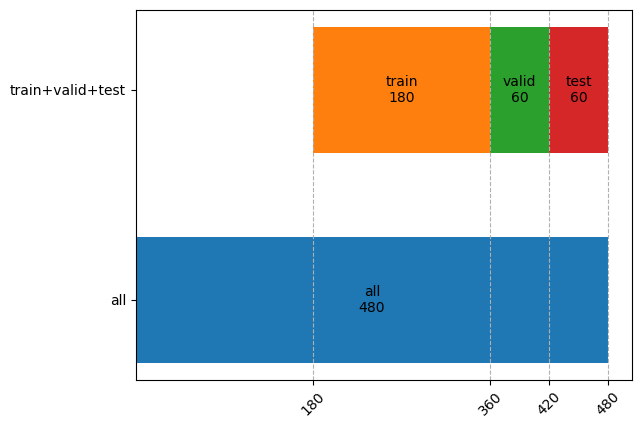

train_X.shape: (1972959, 97), train_y.shape: (1972959, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 8)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.372710215596304


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.5402479	test: 6.4921046	best: 6.4921046 (0)	total: 9.28ms	remaining: 46.4s
100:	learn: 6.4984802	test: 6.4530165	best: 6.4530165 (100)	total: 916ms	remaining: 44.4s
200:	learn: 6.4779871	test: 6.4341271	best: 6.4341271 (200)	total: 1.83s	remaining: 43.6s
300:	learn: 6.4662013	test: 6.4235762	best: 6.4235762 (300)	total: 2.74s	remaining: 42.7s
400:	learn: 6.4587526	test: 6.4170893	best: 6.4170893 (400)	total: 3.63s	remaining: 41.7s
500:	learn: 6.4534271	test: 6.4125404	best: 6.4125404 (500)	total: 4.54s	remaining: 40.7s
600:	learn: 6.4492288	test: 6.4090902	best: 6.4090902 (600)	total: 5.44s	remaining: 39.8s
700:	learn: 6.4454117	test: 6.4060520	best: 6.4060520 (700)	total: 6.33s	remaining: 38.8s
800:	learn: 6.4420026	test: 6.4034404	best: 6.4034404 (800)	total: 7.22s	remaining: 37.9s
900:	learn: 6.4389290	test: 6.4011107	best: 6.4011107 (900)	total: 8.11s	remaining: 36.9s
1000:	learn: 6.4362366	test: 6.3990651	best: 6.3990651 (1000)	total: 8.98s	remaining: 35.9s
1100:	learn

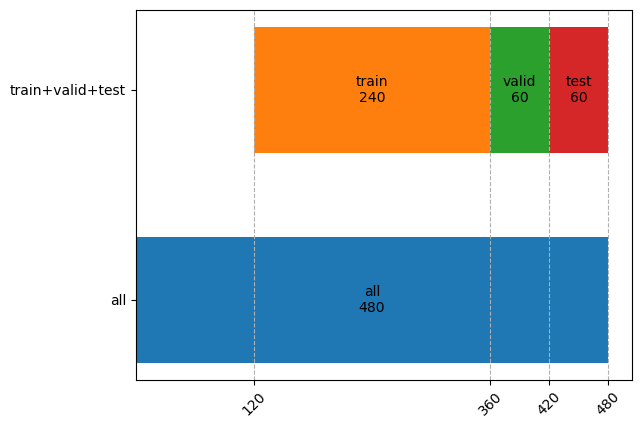

train_X.shape: (2623004, 97), train_y.shape: (2623004, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 9)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.374531410287123


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.7225243	test: 6.4920668	best: 6.4920668 (0)	total: 11.9ms	remaining: 59.7s
100:	learn: 6.6754462	test: 6.4523241	best: 6.4523241 (100)	total: 1.15s	remaining: 55.9s
200:	learn: 6.6517321	test: 6.4332800	best: 6.4332800 (200)	total: 2.3s	remaining: 55s
300:	learn: 6.6380905	test: 6.4230474	best: 6.4230474 (300)	total: 3.44s	remaining: 53.8s
400:	learn: 6.6293799	test: 6.4168817	best: 6.4168817 (400)	total: 4.6s	remaining: 52.7s
500:	learn: 6.6233807	test: 6.4126927	best: 6.4126927 (500)	total: 5.74s	remaining: 51.6s
600:	learn: 6.6185923	test: 6.4095228	best: 6.4095228 (600)	total: 6.88s	remaining: 50.4s
700:	learn: 6.6146594	test: 6.4069604	best: 6.4069604 (700)	total: 8.03s	remaining: 49.2s
800:	learn: 6.6113494	test: 6.4047254	best: 6.4047254 (800)	total: 9.15s	remaining: 48s
900:	learn: 6.6079998	test: 6.4022850	best: 6.4022850 (900)	total: 10.3s	remaining: 46.7s
1000:	learn: 6.6051924	test: 6.4003993	best: 6.4003993 (1000)	total: 11.4s	remaining: 45.4s
1100:	learn: 6.60

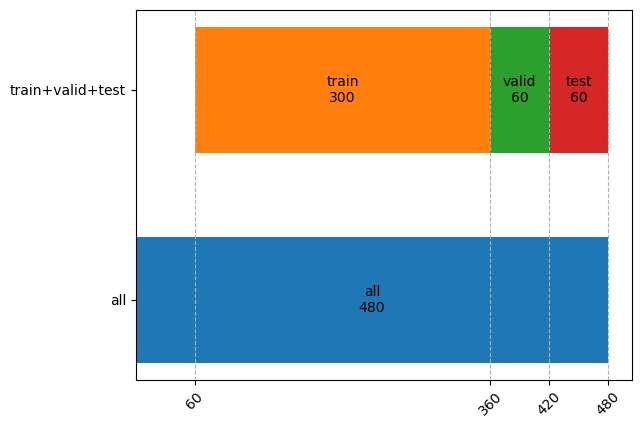

train_X.shape: (3271014, 97), train_y.shape: (3271014, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 10)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.374347319837816


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.7362292	test: 6.4920509	best: 6.4920509 (0)	total: 14.7ms	remaining: 1m 13s
100:	learn: 6.6855312	test: 6.4516407	best: 6.4516407 (100)	total: 1.4s	remaining: 1m 7s
200:	learn: 6.6601617	test: 6.4327611	best: 6.4327611 (200)	total: 2.78s	remaining: 1m 6s
300:	learn: 6.6458193	test: 6.4227739	best: 6.4227739 (300)	total: 4.16s	remaining: 1m 4s
400:	learn: 6.6368215	test: 6.4168931	best: 6.4168931 (400)	total: 5.5s	remaining: 1m 3s
500:	learn: 6.6306809	test: 6.4129534	best: 6.4129534 (500)	total: 6.86s	remaining: 1m 1s
600:	learn: 6.6260059	test: 6.4098455	best: 6.4098455 (600)	total: 8.2s	remaining: 1m
700:	learn: 6.6220811	test: 6.4073150	best: 6.4073150 (700)	total: 9.55s	remaining: 58.5s
800:	learn: 6.6187763	test: 6.4051338	best: 6.4051338 (800)	total: 10.9s	remaining: 57s
900:	learn: 6.6157681	test: 6.4031056	best: 6.4031056 (900)	total: 12.2s	remaining: 55.5s
1000:	learn: 6.6131897	test: 6.4013630	best: 6.4013630 (1000)	total: 13.5s	remaining: 54s
1100:	learn: 6.61076

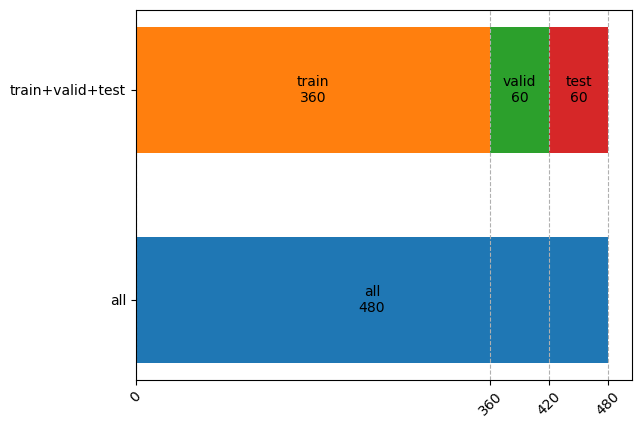

train_X.shape: (3906948, 97), train_y.shape: (3906948, 6)
valid_X.shape: (659945, 97), valid_y.shape: (659945, 6)
test_X.shape: (659999, 97), test_y.shape: (659999, 11)


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


depth: 5
learning_rate: 0.0951207163345817
subsample: 0.839196365086843
loss_function: MAE
eval_metric: MAE
iterations: 5000
random_state: 42
bootstrap_type: Poisson
task_type: GPU
best value: 6.3741394045377024


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4935791	test: 6.4920660	best: 6.4920660 (0)	total: 17.4ms	remaining: 1m 26s
100:	learn: 6.4415252	test: 6.4509489	best: 6.4509489 (100)	total: 1.68s	remaining: 1m 21s
200:	learn: 6.4162502	test: 6.4322868	best: 6.4322868 (200)	total: 3.34s	remaining: 1m 19s
300:	learn: 6.4023330	test: 6.4225807	best: 6.4225807 (300)	total: 4.99s	remaining: 1m 17s
400:	learn: 6.3936746	test: 6.4169507	best: 6.4169507 (400)	total: 6.64s	remaining: 1m 16s
500:	learn: 6.3877948	test: 6.4131738	best: 6.4131738 (500)	total: 8.27s	remaining: 1m 14s
600:	learn: 6.3832915	test: 6.4101289	best: 6.4101289 (600)	total: 9.9s	remaining: 1m 12s
700:	learn: 6.3798141	test: 6.4078499	best: 6.4078499 (700)	total: 11.5s	remaining: 1m 10s
800:	learn: 6.3765804	test: 6.4056838	best: 6.4056838 (800)	total: 13.1s	remaining: 1m 8s
900:	learn: 6.3738350	test: 6.4038064	best: 6.4038064 (900)	total: 14.7s	remaining: 1m 6s
1000:	learn: 6.3712811	test: 6.4019123	best: 6.4019123 (1000)	total: 16.3s	remaining: 1m 5s
1100

In [6]:
history, test_y, fimps, best_params_records = train(
    dataset=train_df,
    outputs_dir=outputs_dir_path,
)

,stock_id,date_id,seconds_in_bucket,target,ask_size,bid_size,regression_fold1,regression_fold2,regression_fold3,regression_fold4,regression_fold5,regression_fold6,regression
4566980,0,420,0,-2.239943,16486.08,38181.63,0.267540,-0.173596,-0.354975,-0.217315,-0.222169,-0.442390,-0.190484
4566981,1,420,0,25.689602,193536.00,1071.72,2.358109,2.890914,3.190691,2.706328,3.106129,3.336520,2.931449
4566982,2,420,0,-2.110004,4359.80,30462.60,-8.885684,-9.423059,-9.639488,-10.127099,-9.492476,-9.474506,-9.507052
4566983,3,420,0,-4.789829,39294.81,949.00,0.368490,0.450369,0.466484,0.432000,0.479213,0.511821,0.451396
4566984,4,420,0,-3.380179,1303.04,7814.88,-1.111249,-1.402033,-1.468796,-1.422253,-1.264389,-1.309703,-1.329737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226975,195,479,540,1.599789,201285.80,347029.41,0.413044,0.445175,0.642298,0.774403,0.789389,0.723852,0.631360
5226976,196,479,540,-8.440018,86991.97,339588.62,0.389561,0.689841,1.211562,1.239272,1.042508,1.143862,0.952768
5226977,197,479,540,5.149841,84439.68,152726.40,-1.651970,-2.133724,-2.185108,-2.296941,-2.015518,-2.051064,-2.055721
5226978,198,479,540,-0.249743,872013.89,1177519.48,-1.699235,-1.834129,-2.219422,-2.275949,-2.309810,-2.354970,-2.115586


,fold1,fold2,fold3,fold4,fold5,fold6,mean_fimps,std_fimps
wap,0.868326,0.472235,0.229055,0.479080,0.531589,0.656202,0.539415,0.212772
diff_bid_price_reference_price,1.056993,0.845459,0.457653,0.382854,0.218614,0.313775,0.545891,0.330552
robust_scaled_feature13,0.301850,0.305080,0.576799,0.504595,0.785179,0.873902,0.557901,0.238408
robust_scaled_bid_price,0.555497,0.686920,0.768595,0.468340,0.565622,0.403734,0.574785,0.135042
robust_scaled_reference_price,0.426534,0.563523,0.556784,0.636876,0.728708,0.670094,0.597087,0.105902
diff_imbalance_size_matched_size,0.957525,1.018610,0.673936,0.427110,0.285733,0.243313,0.601038,0.335976
robust_scaled_feature11,0.613915,0.708827,0.502298,0.477519,0.688280,0.625500,0.602723,0.094851
stock_id,1.251554,0.764865,0.724211,0.552884,0.387780,0.295587,0.662813,0.341580
feature12,1.443337,0.890555,0.530154,0.458601,0.464784,0.560855,0.724714,0.386524
reference_price,1.477811,0.832395,0.764867,0.479268,0.390389,0.448052,0.732131,0.407085


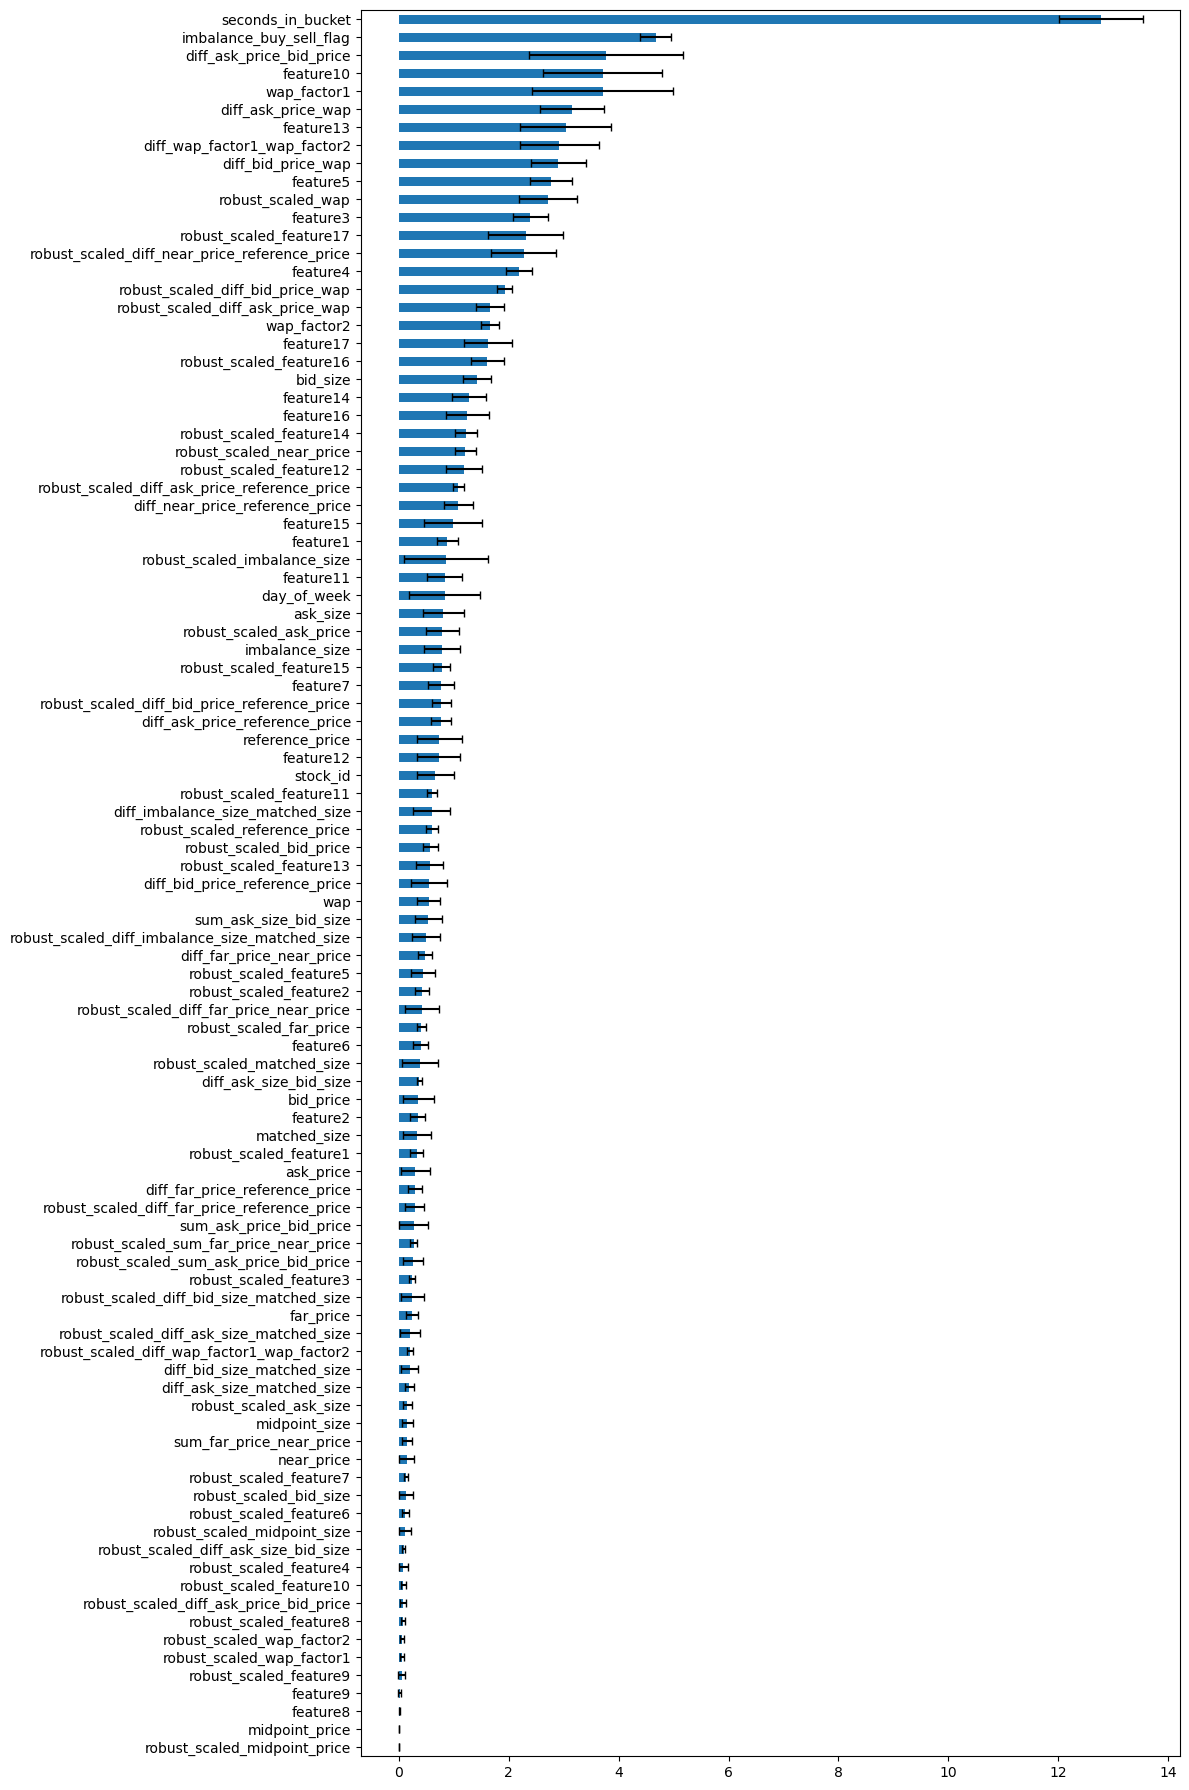

In [7]:
display(test_y)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(12, 18))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)
plt.tight_layout()
plt.show()

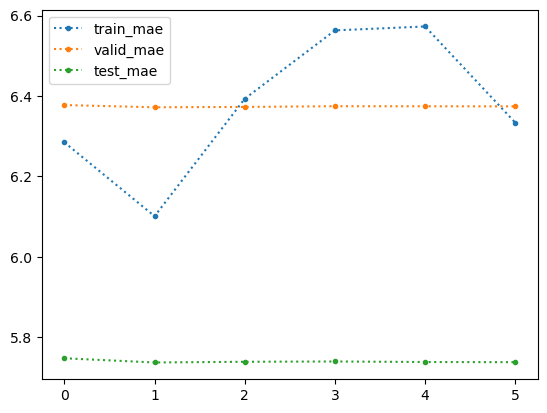

In [8]:
history.plot(marker='.', linestyle=':')
plt.show()

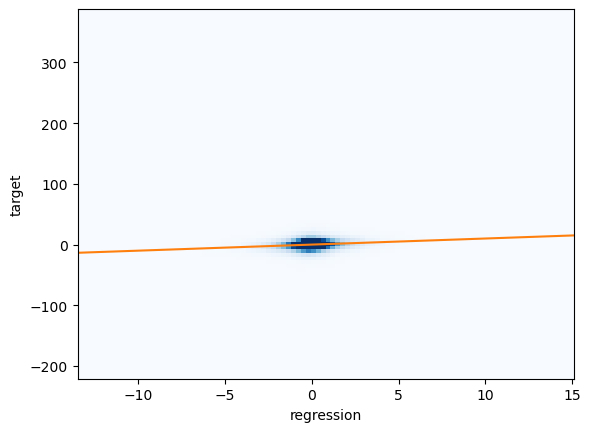

correlation coeeficient: 0.1628


In [9]:
_, ax = plt.subplots()
ax.hist2d(test_y['regression'], test_y['target'], bins=100, cmap='Blues', vmax=1e+04)
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(test_y['regression'], test_y['target'])
print(f'correlation coeeficient: {r[0, 1]:.4f}')

In [10]:
correlation_efficients = []
for stock in range(200):
    data = test_y.query('stock_id==@stock')
    r = np.corrcoef(data['regression'], data['target'])
    correlation_efficients.append((stock, r[0, 1]))
correlation_efficients = pd.DataFrame(correlation_efficients, columns=['stock_id', 'r'])
display(correlation_efficients)
display(correlation_efficients.describe())

,stock_id,r
0,0,0.108294
1,1,0.287722
2,2,0.152234
3,3,0.188706
4,4,0.171935
...,...,...
195,195,0.093118
196,196,0.047195
197,197,0.164289
198,198,0.084801


,stock_id,r
count,200.000000,200.000000
mean,99.500000,0.150427
std,57.879185,0.080271
min,0.000000,-0.013945
25%,49.750000,0.093111
50%,99.500000,0.132536
75%,149.250000,0.196832
max,199.000000,0.354337


In [11]:
q1 = correlation_efficients['r'].quantile(0.25)
q3 = correlation_efficients['r'].quantile(0.75)
print(f'correlation coefficient q1: {q1:.4f}')
print(f'correlation coefficient q3: {q3:.4f}')
display(correlation_efficients.query('r < @q1')['stock_id'].values)
display(correlation_efficients.query('r > @q3')['stock_id'].values)

correlation coefficient q1: 0.0931
correlation coefficient q3: 0.1968


array([ 10,  18,  26,  30,  38,  49,  50,  53,  76,  78,  79,  84,  86,
        88,  91,  93,  99, 100, 112, 117, 120, 121, 129, 130, 131, 135,
       139, 140, 144, 145, 151, 153, 154, 156, 161, 165, 166, 168, 172,
       174, 176, 178, 179, 182, 188, 189, 191, 194, 196, 198])

array([  1,   6,   7,   8,  16,  17,  19,  20,  29,  33,  34,  37,  39,
        42,  43,  54,  57,  58,  62,  64,  71,  74,  77,  80,  85,  89,
        90,  92,  94, 101, 107, 108, 114, 115, 118, 119, 127, 133, 138,
       143, 146, 149, 152, 157, 163, 169, 171, 173, 177, 185])

## train catboost model using all data

In [12]:
best_params = pd.DataFrame(best_params_records)
display(best_params)

new_best_params = {}
for idx in best_params.index:
    if best_params.loc[idx].nunique() > 1:
        new_best_params[idx] = best_params.loc[idx].mean().item()
    else:
        new_best_params[idx] = best_params.loc[idx].unique().item()
    if isinstance(best_params.loc[idx].iloc[0], int):
        new_best_params[idx] = int(new_best_params[idx])

num_boost_round = new_best_params.pop('num_boost_round')
print(new_best_params)

,fold1,fold2,fold3,fold4,fold5,fold6
depth,5,5,5,5,5,5
learning_rate,0.095121,0.095121,0.095121,0.095121,0.095121,0.095121
subsample,0.839196,0.839196,0.839196,0.839196,0.839196,0.839196
loss_function,MAE,MAE,MAE,MAE,MAE,MAE
eval_metric,MAE,MAE,MAE,MAE,MAE,MAE
iterations,5000,5000,5000,5000,5000,5000
random_state,42,42,42,42,42,42
bootstrap_type,Poisson,Poisson,Poisson,Poisson,Poisson,Poisson
task_type,GPU,GPU,GPU,GPU,GPU,GPU
num_boost_round,4996,4998,4995,4998,4998,4999


{'depth': 5, 'learning_rate': 0.0951207163345817, 'subsample': 0.839196365086843, 'loss_function': 'MAE', 'eval_metric': 'MAE', 'iterations': 5000, 'random_state': 42, 'bootstrap_type': 'Poisson', 'task_type': 'GPU'}


In [13]:
target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
feature_columns = [col for col in train_df.columns if col not in ['date_id', 'target']]


train_pool = Pool(
    data=train_df[feature_columns],
    label=train_df[target_columns]['target'],
)

model = CatBoostRegressor(**new_best_params)
model.fit(
    X=train_pool,
    use_best_model=True,
    verbose=100,
)

model.save_model(
    outputs_dir_path.joinpath(f'catboost_trained_using_alldata')
)

You should provide test set for use best model. use_best_model parameter has been switched to false value.
Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4068133	total: 23.1ms	remaining: 1m 55s
100:	learn: 6.3585049	total: 2.22s	remaining: 1m 47s
200:	learn: 6.3353311	total: 4.4s	remaining: 1m 45s
300:	learn: 6.3225328	total: 6.57s	remaining: 1m 42s
400:	learn: 6.3146884	total: 8.7s	remaining: 1m 39s
500:	learn: 6.3093187	total: 10.8s	remaining: 1m 37s
600:	learn: 6.3049838	total: 13s	remaining: 1m 34s
700:	learn: 6.3013919	total: 15.1s	remaining: 1m 32s
800:	learn: 6.2983666	total: 17.2s	remaining: 1m 30s
900:	learn: 6.2956961	total: 19.3s	remaining: 1m 27s
1000:	learn: 6.2933569	total: 21.4s	remaining: 1m 25s
1100:	learn: 6.2913046	total: 23.4s	remaining: 1m 22s
1200:	learn: 6.2893576	total: 25.5s	remaining: 1m 20s
1300:	learn: 6.2874305	total: 27.6s	remaining: 1m 18s
1400:	learn: 6.2856936	total: 29.6s	remaining: 1m 16s
1500:	learn: 6.2841452	total: 31.7s	remaining: 1m 13s
1600:	learn: 6.2826488	total: 33.8s	remaining: 1m 11s
1700:	learn: 6.2812387	total: 35.9s	remaining: 1m 9s
1800:	learn: 6.2799019	total: 37.9s	remainin